In [1]:
import simulate
import withdrawal
import market
import harvesting
import metrics
import lens

from decimal import Decimal
import decimal
import itertools
import pandas
import numpy
import math

In [2]:
%matplotlib inline
#%pdb on
import seaborn
from matplotlib import pyplot as plt
import matplotlib
seaborn.set(style="whitegrid")
seaborn.set_context('poster')

In [3]:
stock_er = Decimal('.05')
bond_er = Decimal('.018')
inflation = Decimal('.02')
stock_pct = Decimal('.6')
discount_rate = (stock_pct * stock_er) + ((1-stock_pct) * bond_er)
#discount_rate = Decimal('.0054')
max_age = 92 # 95th percentile SOA2012 for 65/65 male/female
expenses = 40_000

def pv_expenses(age):
    years = max_age - age + 1
    e = [expenses] * years
    npv = numpy.npv(discount_rate, e)
    return npv

In [4]:
print(discount_rate)

0.0372


In [5]:
pv_expenses(70)

Decimal('633829.1465461964394275225119')

In [6]:
def run(age, funded_ratio):
    npv = pv_expenses(age)
    portfolio_value = npv * funded_ratio
    portfolio = (portfolio_value, 0) # this is a 100/0 portfolio but it'll get rebalanced before we start.
    iwd = expenses / portfolio_value
    wd_s = lambda p, h: withdrawal.ConstantDollar(p, h, rate=iwd)
    df = simulate.calc_lens(lambda p: harvesting.AgeBased(p, 100, starting_age=age), wd_s, max_age-age, lens.calc_years_sustained, portfolio=portfolio)
    return df

In [7]:
#run(70, Decimal('1.0')).head()

In [8]:
def long_sim():
    data = pandas.DataFrame(columns=['age', 'funded_ratio', 'failure_rate'])
    for age in range(40, 90):
        for funded in range(80, 251, 1):
            f = Decimal(funded) / 100
            s = run(age, f)
            failures = len(s[s<0])
            count = len(s)
            failure_rate = failures / count
            data = data.append({'age': age, 'funded_ratio': f, 'failure_rate': failure_rate}, ignore_index=True)
    print(data.head())
    return data

In [9]:
data = long_sim()
#data.to_csv('funded_failures.csv')
#data = pandas.read_csv('funded_failures.csv')

/home/justus/Dropbox/jupyter/prime-harvesting/lens.py:38: FutureWarning: `item` has been deprecated and will be removed in a future version
  b_t = df.tail(1)['portfolio_post'].item().value_r


  age funded_ratio  failure_rate
0  40          0.8      0.739583
1  40         0.81      0.729167
2  40         0.82      0.708333
3  40         0.83      0.697917
4  40         0.84      0.687500


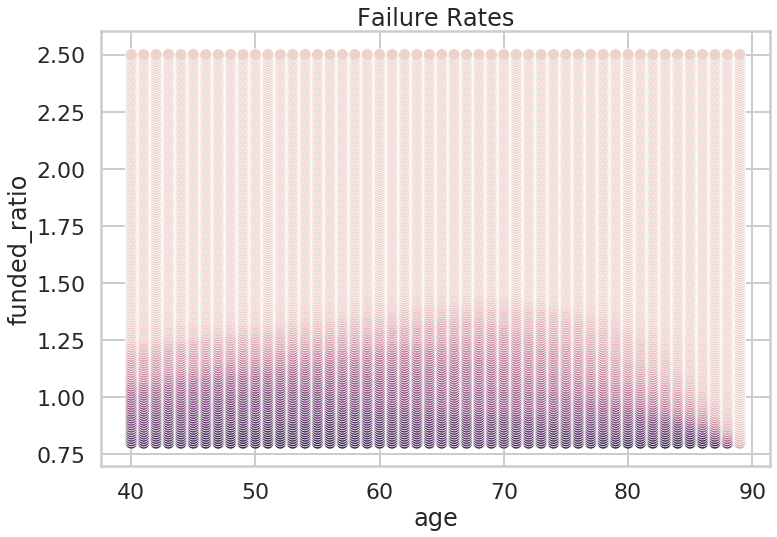

In [10]:
plt.figure(figsize=(12,8))
plt.title('Failure Rates')
seaborn.scatterplot(data=data, x='age', y='funded_ratio', hue='failure_rate', legend=False)

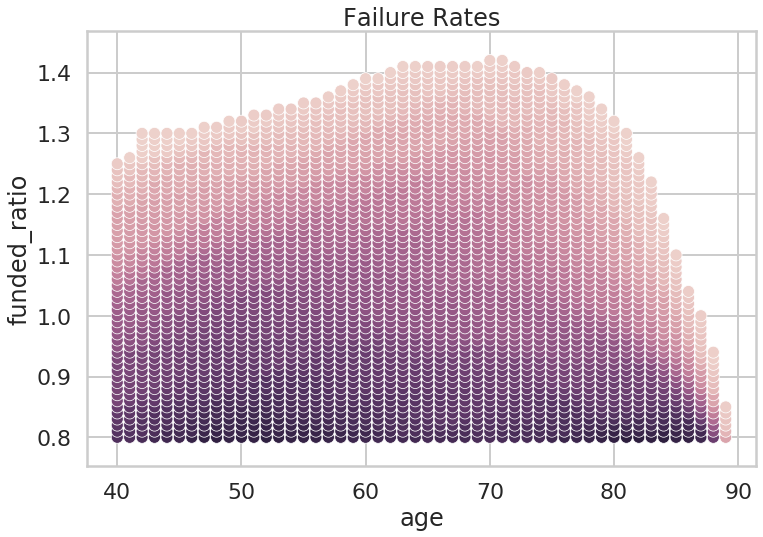

In [11]:
plt.figure(figsize=(12,8))
plt.title('Failure Rates')
seaborn.scatterplot(data=data[data['failure_rate']>0.05], x='age', y='funded_ratio', hue='failure_rate', legend=False)

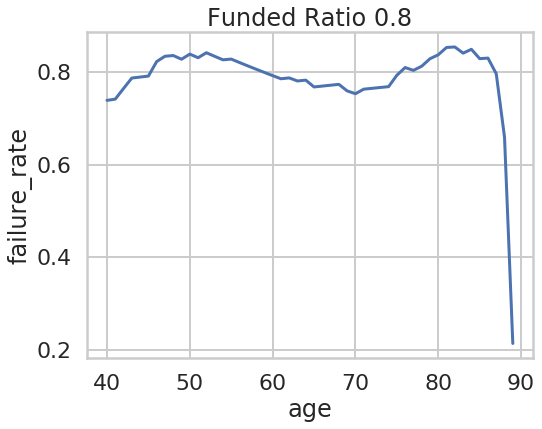

In [12]:
plt.figure(figsize=(8,6))
plt.title('Funded Ratio 0.8')
seaborn.lineplot(data=data[data['funded_ratio'] == Decimal('0.8')], x='age', y='failure_rate')

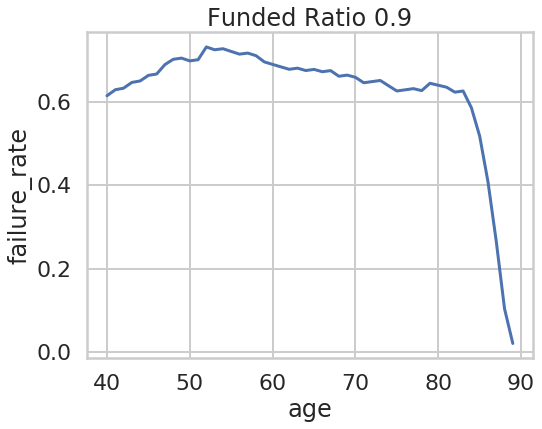

In [13]:
plt.figure(figsize=(8,6))
plt.title('Funded Ratio 0.9')
seaborn.lineplot(data=data[data['funded_ratio'] == Decimal('0.9')], x='age', y='failure_rate')

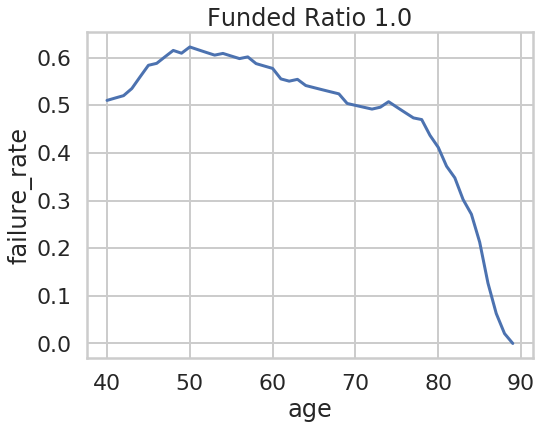

In [14]:
plt.figure(figsize=(8,6))
plt.title('Funded Ratio 1.0')
seaborn.lineplot(data=data[data['funded_ratio'] == Decimal('1.0')], x='age', y='failure_rate')

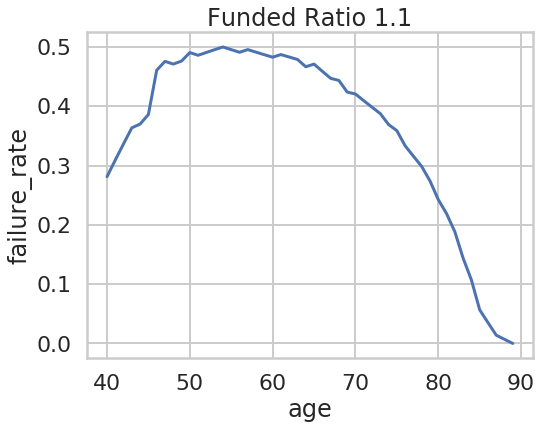

In [15]:
plt.figure(figsize=(8,6))
plt.title('Funded Ratio 1.1')
seaborn.lineplot(data=data[data['funded_ratio'] == Decimal('1.1')], x='age', y='failure_rate')

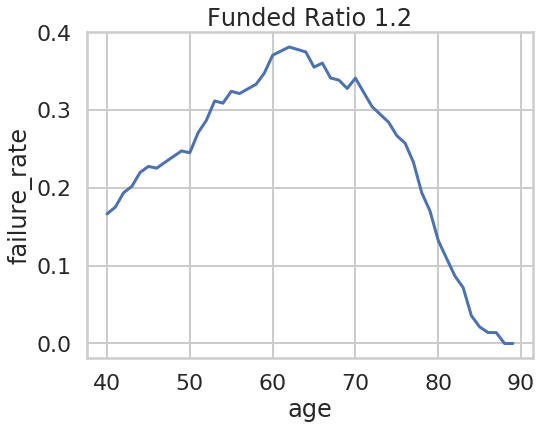

In [16]:
plt.figure(figsize=(8,6))
plt.title('Funded Ratio 1.2')
seaborn.lineplot(data=data[data['funded_ratio'] == Decimal('1.2')], x='age', y='failure_rate')

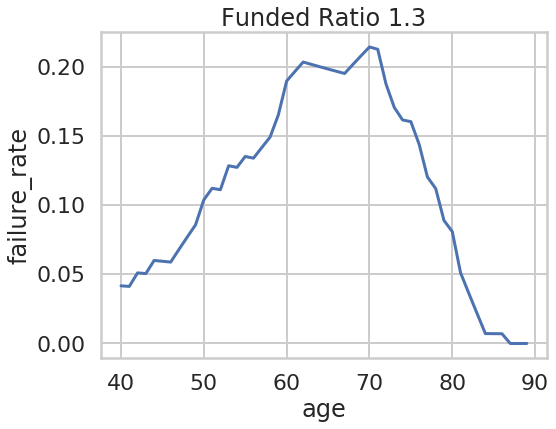

In [17]:
plt.figure(figsize=(8,6))
plt.title('Funded Ratio 1.3')
seaborn.lineplot(data=data[data['funded_ratio'] == Decimal('1.3')], x='age', y='failure_rate')

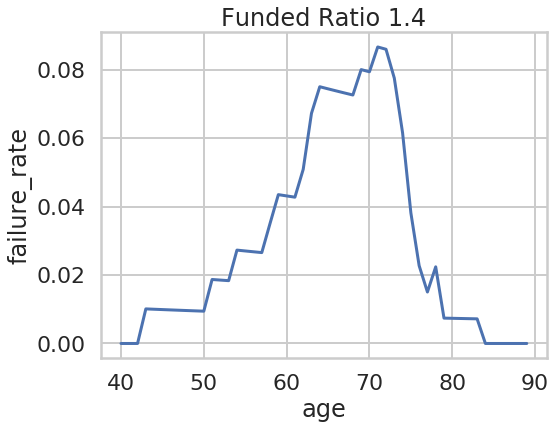

In [18]:
plt.figure(figsize=(8,6))
plt.title('Funded Ratio 1.4')
seaborn.lineplot(data=data[data['funded_ratio'] == Decimal('1.4')], x='age', y='failure_rate')

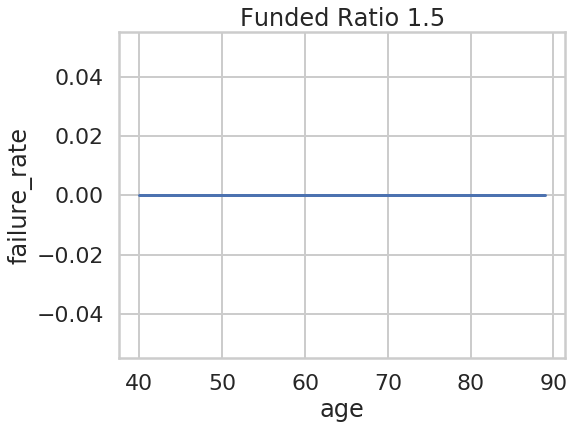

In [19]:
plt.figure(figsize=(8,6))
plt.title('Funded Ratio 1.5')
seaborn.lineplot(data=data[data['funded_ratio'] == Decimal('1.5')], x='age', y='failure_rate')

    funded_ratio  failure_rate
age                           
40          1.26           0.0
41          1.27           0.0
42          1.31           0.0
43          1.31           0.0
44          1.32           0.0


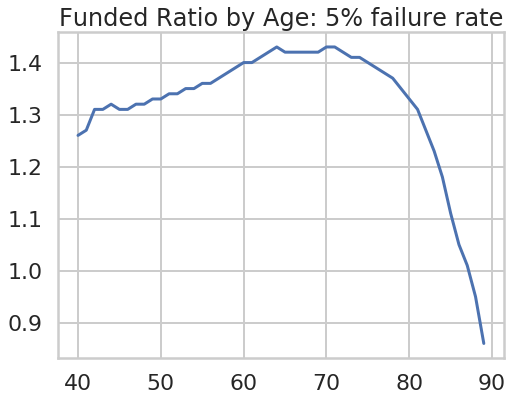

In [20]:
f_by_age = data[data['failure_rate'] <= Decimal('.05')].groupby('age').min()
print(f_by_age.head())
plt.figure(figsize=(8,6))
plt.title('Funded Ratio by Age: 5% failure rate')
seaborn.lineplot(data=f_by_age['funded_ratio'].astype(float))

    funded_ratio  failure_rate
age                           
40          1.38           0.0
41          1.39           0.0
42           1.4           0.0
43          1.41           0.0
44          1.42           0.0


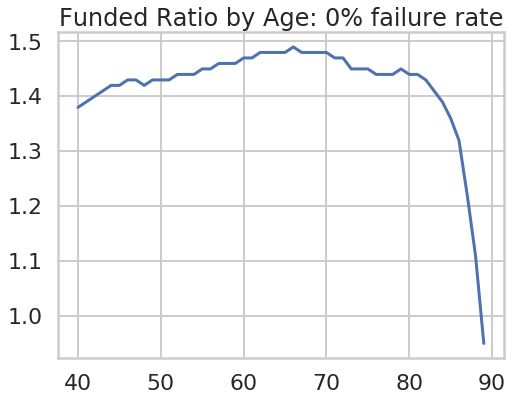

In [21]:
f_by_age = data[data['failure_rate'] <= Decimal('0')].groupby('age').min()
print(f_by_age.head())
plt.figure(figsize=(8,6))
plt.title('Funded Ratio by Age: 0% failure rate')
seaborn.lineplot(data=f_by_age['funded_ratio'].astype(float))

     age funded_ratio  failure_rate
1710  50          0.8      0.839623
1711  50         0.81      0.811321
1712  50         0.82      0.811321
1713  50         0.83      0.801887
1714  50         0.84      0.792453


AttributeError: 'float' object has no attribute 'shape'

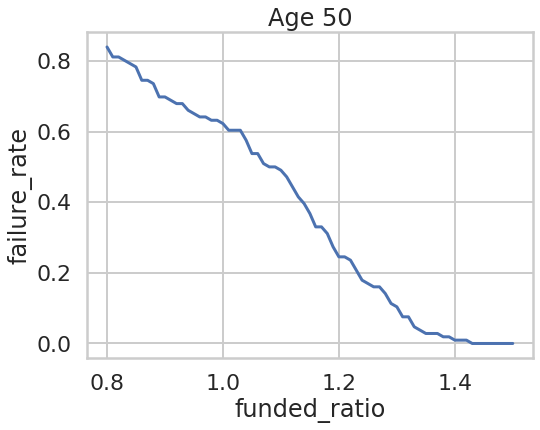

In [22]:
import scipy.stats
for age in [50, 55, 60, 65, 70]:
    f = data[data['age'] == age]
    f = f[f['funded_ratio'] <= Decimal('1.5')]
    print(f.head())
    plt.figure(figsize=(8,6))
    plt.title(f'Age {age}')
    seaborn.lineplot(data=f, x='funded_ratio', y='failure_rate')
    print(age, scipy.stats.linregress(f['funded_ratio'], f['failure_rate']))

In [ ]:
f = data[data['age'] == 50]
f[f['funded_ratio'] <= Decimal('1.11')]

In [ ]:
def sim():
    data = pandas.DataFrame(columns=['age', 'funded_ratio', 'failure_rate'])
    for age in range(40, 90):
        for funded in range(80, 151, 1):
            f = Decimal(funded) / 100
            s = run(age, f)
            failures = len(s[s<0])
            count = len(s)
            failure_rate = failures / count
            data = data.append({'age': age, 'funded_ratio': f, 'failure_rate': failure_rate}, ignore_index=True)
    print(data.head())
    return data

In [ ]:
data_new = sim()
#data_new.to_csv('funded_failures_tips.csv')
#data_new = pandas.read_csv('funded_failures_tips.csv')

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Funded Ratio 1.0')
seaborn.lineplot(data=data_new[data_new['funded_ratio'] == Decimal('1.0')], x='age', y='failure_rate')

In [ ]:
new = pandas.DataFrame(data_new[data_new['funded_ratio'] == Decimal('1.0')])
new['discount'] = '0.54%'

In [ ]:
old = pandas.DataFrame(data[data['funded_ratio'] == Decimal('1.0')])
old['discount'] = '3.73%'

In [ ]:
joint = old.append(new)

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Funded Ratio 1.0')
seaborn.lineplot(data=joint, x='age', y='failure_rate', hue='discount')

In [ ]:
f_by_age = data_new[data_new['failure_rate'] <= Decimal('0')].groupby('age').min()
print(f_by_age.head())
plt.figure(figsize=(8,6))
plt.title('Funded Ratio (0.54% discount rate) by Age: 0% failure rate')
seaborn.lineplot(data=f_by_age['funded_ratio'].astype(float))